# Medication Compliance Forecasting 

### Objective 
Predict patient’s likelihood of adherence to a prescribed regimen. For that,information is provided both for patient and the prescription. Patient information include details like age, gender, medical history, cultural background etc. Details about the prescription are like Diet control advised, Exercise advised etc.

To build a predictive model, with the provided a data set that contains details about patient and the prescription.


### Evaluation 
For each patient id in test set, you must predict if a patient is going to adhere to the prescribed regimen. Your model will be evaluated on precision and recall for both the outcomes. So, your code must include generation of confusion matrix for your predictions.

# Setup
Setting up project directory and output paths, for data and model.

### Step 1 : Standard Imports

In [1]:
#Common imports
import numpy as np
import pandas as pd
import os
import sys

#To make outputs more consistent
np.random.seed(42)

#To Save & Load Models
import pickle

#To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "whitegrid", color_codes = True)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Preprocessing imports

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

# Models Imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve,roc_curve , roc_auc_score


from sklearn.model_selection import GridSearchCV


#Folder Directory Structure
PROJECT_ROOT_DIR ='.'
PROJECT_DATA_DIR = './data'

PROJECT_FOLDER = 'medical_compliance_forecasting'
PROJECT_ID=PROJECT_FOLDER
PROJECT_OUTPUT_PATH = os.path.join(PROJECT_ROOT_DIR,'model',PROJECT_ID)
TRAINING_DATA =  os.path.join(PROJECT_DATA_DIR,PROJECT_FOLDER,'Training Data.csv')
TEST_DATA =  os.path.join(PROJECT_DATA_DIR,PROJECT_FOLDER,'Test Data.csv')

### Step 2a : Utility Functions

In [2]:
def save_fig(fig_id,tight_layout=True,fig_extension='png',resolution=300):
    if not os.path.exists(IMAGES_PATH):
        os.makedirs(PROJECT_OUTPUT_PATH)
    path = os.path.join(PROJECT_OUTPUT_PATH,fig_id + '.' + fig_extension)
    print("Saving Figure : {}".format(fig_id))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)

def save_model(model,model_name):
    model_file = os.path.join(PROJECT_OUTPUT_PATH,model_name+'.pkl')
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    
def load_model(model,model_name):
    model_file = os.path.join(PROJECT_OUTPUT_PATH,model_name+'.pkl')
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
    return model

def load_data(path=TRAINING_DATA):
    data_file = os.path.join(path)
    return pd.read_csv(data_file)


### Step 2b : Visualization Functions

In [3]:

# Used to See Correleation in Data against a selected Feature
def get_correlation(corr_matrix,data,feature):
    return corr_matrix[feature].sort_values(ascending=False)

def get_best_params(classifier, param_grid, processed_training_data,
                    processed_training_label, cv=5):
    
    grid_search = GridSearchCV(classifier, param_grid, cv=cv,
                               scoring='f1_macro', return_train_score=True ,
                               n_jobs =-1 )
    
    grid_search.fit(processed_training_data, processed_training_label)
    print("Best parameters : {}".format(grid_search.best_params_))
    print("Best Score : {}".format(grid_search.best_score_))
    

# To compute & display Precision,Recall & F1 Score

def compute_scores(y_label,y_predicted):
    print("Classsification Report - ")
    print(classification_report(y_label, y_predicted))
    cnf_matrix = confusion_matrix(y_label, y_predicted)
    plot_confusion_matrix(cnf_matrix)
    
    precisions, recalls, thresholds = precision_recall_curve(processed_training_label, predicted_label)
    fpr, tpr, thresholds = roc_curve(processed_training_label, predicted_label)
    logit_roc_auc = roc_auc_score(processed_training_label, predicted_label)
    
    print("Plots for Precision Recall & ROC can be visualised below")
    plot_precision_vs_recall(precisions, recalls)
    plot_roc_curve(fpr, tpr,logit_roc_auc, label=None)
    
    
def plot_confusion_matrix(cnf_matrix):
    plt.clf()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix for Medical Compliance')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cnf_matrix[i][j]))
    plt.show()
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1,])
    plt.figure(figsize=(8, 6))
    plt.show()


def plot_roc_curve(fpr, tpr,logit_roc_auc, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic',fontsize=14)
    plt.text(0.5,0.3,'Area under the Graph - %0.2f'%logit_roc_auc)
    plt.figure(figsize=(8, 6))
    plt.show()
    

### Step 3 
Since we already have different Training & Test sets, we don't neeed to create any splits. Hence, directly loading the data


In [4]:
dataset =  load_data(path=TRAINING_DATA)
test_set = load_data(path=TEST_DATA)

### Step 4 : Exploratory Data Analysis

In [5]:
# View Train Data
dataset.head(2)

,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
0,1,19,M,7,0,0,0,0,0,0,No
1,2,24,F,59,0,0,0,0,0,0,No


In [6]:
# View Test Data
test_set.head(2)

,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder
0,1,5,M,28,0,0,0,0,0,1
1,2,62,F,9,1,0,1,0,0,0


In [7]:
# Checking all description of the columns for their Data-types, counts & Nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180212 entries, 0 to 180211
Data columns (total 11 columns):
patient_id             180212 non-null int64
Age                    180212 non-null int64
Gender                 180212 non-null object
Prescription_period    180212 non-null int64
Diabetes               180212 non-null int64
Alcoholism             180212 non-null int64
HyperTension           180212 non-null int64
Smokes                 180212 non-null int64
Tuberculosis           180212 non-null int64
Sms_Reminder           180212 non-null int64
Adherence              180212 non-null object
dtypes: int64(9), object(2)
memory usage: 15.1+ MB


In [8]:
#Let's see the distribution and attributes of the Age & Prescription Period which have a range of values
dataset[['Age','Prescription_period']].describe()

,Age,Prescription_period
count,180212.000000,180212.000000
mean,37.795363,54.668485
std,22.852072,35.752491
min,0.000000,1.000000
25%,19.000000,22.000000
50%,38.000000,51.000000
75%,56.000000,86.000000
max,113.000000,120.000000


In [9]:
# Since we see Objects types / Categorical Values, let's see the count
print("Gender Distribution - ")
print(dataset['Gender'].value_counts())
print()
print("Adherence Distribution - ")
print(dataset['Adherence'].value_counts())

Gender Distribution - 
F    120438
M     59774
Name: Gender, dtype: int64

Adherence Distribution - 
No     125822
Yes     54390
Name: Adherence, dtype: int64


#### Inference 1 -

1. We can see the data has no null/missing values.
2. We see that Gender & Adherence are categorical values
3. We can also see that "F"emale patients data is more than "M"ale. Though the data is not imbalanced.
4. We can also see that Adherence is dominated by "N"o but is not imbalanced.
5. Since we have categorical values, we need to convert them.
6. Since our data does not have any missing value, we don't require any imputer for filling nulls.

In [10]:
# Defining Numerical & Categorical Categories
num_attribs = list(dataset.drop(['Gender','Adherence'], axis=1))
cat_attribs = ['Gender','Adherence']

print("Numerical Categories in Source Data : {}".format(num_attribs))
print("Categorical Categories in Source Data : {}".format(cat_attribs))

Numerical Categories in Source Data : ['patient_id', 'Age', 'Prescription_period', 'Diabetes', 'Alcoholism', 'HyperTension', 'Smokes', 'Tuberculosis', 'Sms_Reminder']
Categorical Categories in Source Data : ['Gender', 'Adherence']


In [11]:
# Creating Encoder for Categorical Values
ordinal_encoder = OrdinalEncoder()
gender = ordinal_encoder.fit_transform(dataset[['Gender']])
adherence = ordinal_encoder.fit_transform(dataset[['Adherence']])

#Creating a copy of the Orginial Dataset to update the values for Further analysis
dataset_numerical = dataset.copy()
dataset_numerical['Gender'] = gender
dataset_numerical['Adherence'] = adherence


In [12]:
dataset_numerical.head()

,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
0,1,19,1.0,7,0,0,0,0,0,0,0.0
1,2,24,0.0,59,0,0,0,0,0,0,0.0
2,3,4,0.0,43,0,0,0,0,0,0,0.0
3,4,38,1.0,66,0,0,0,0,0,1,0.0
4,5,46,0.0,98,0,0,0,0,0,1,0.0


In [13]:
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

data_prepared = full_pipeline.fit_transform(dataset)

/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


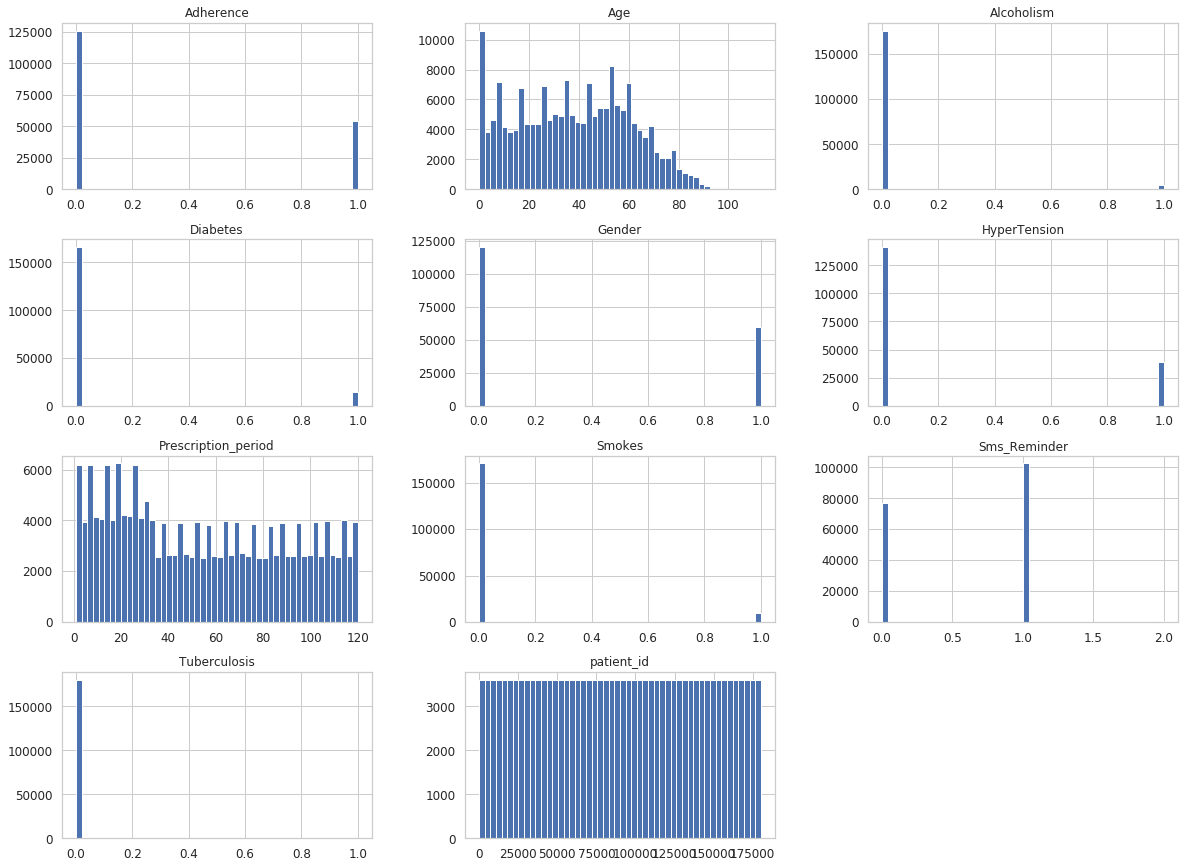

In [14]:
#We can see the graphical distribution too as follows 
#Vertical Axis has number of instances
#Horizontal Axis has values of the attributes
dataset_numerical.hist(bins=50,figsize=(20,15))
plt.show()

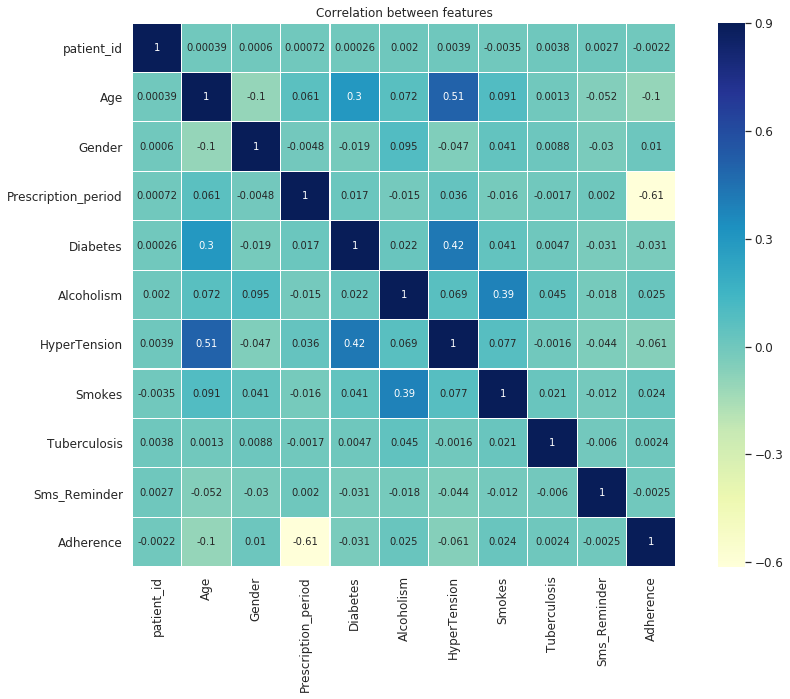

In [15]:
## We also create the correlation between features -
corr = dataset_numerical.corr()
plt.figure(figsize=(15, 10))

sns.heatmap(corr, vmax=.9, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [16]:
get_correlation(dataset_numerical.corr(),dataset_numerical,'Adherence')

Adherence              1.000000
Alcoholism             0.024982
Smokes                 0.023993
Gender                 0.010232
Tuberculosis           0.002359
patient_id            -0.002155
Sms_Reminder          -0.002519
Diabetes              -0.031004
HyperTension          -0.061314
Age                   -0.100818
Prescription_period   -0.612656
Name: Adherence, dtype: float64

#### Inference 2

1. From the histogram distribution we can infer that all the fields have binary values.
2. The Ordinal Encoder is able to encode the Categorical Categories
3. The Correlation Heat-map shoes some features being related to each other.
4. The correlation with the target field, 'Adherence' shows that Prescription_period & Age highly affect the compliance to the prescription.

### Step 5 : Data Pre-processing

Since we can see that "Prescription_period" affect the target inversely, it is important for us to have a equal distribution of it , in the training & test dataset. Hence, we would go for a StratifiedShuffleSplit.

Steps to be followed - 

1. Pipeline to process input data for training.
2. Create Training-Test Split

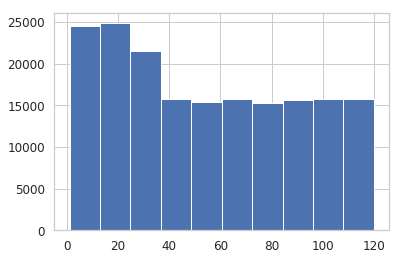

In [17]:
dataset["Prescription_period"].hist()

In [18]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset, dataset["Prescription_period"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [19]:
# Printing Top 10 values of the test split set
print((strat_test_set["Prescription_period"].value_counts() / len(strat_test_set))[0:10])

30    0.019033
22    0.011791
29    0.011736
19    0.011680
23    0.011653
21    0.011625
9     0.011625
15    0.011597
3     0.011597
24    0.011570
Name: Prescription_period, dtype: float64


In [20]:
# Printing Top 10 values of the original DataSet
print((dataset["Prescription_period"].value_counts() / len(dataset))[0:10])

30    0.019033
22    0.011786
29    0.011736
19    0.011664
23    0.011653
9     0.011625
21    0.011609
3     0.011603
15    0.011592
24    0.011575
Name: Prescription_period, dtype: float64


In [21]:
# Separating Features & Target for training

training_data = strat_train_set.drop(['Adherence','patient_id'],axis=1)
training_label = strat_train_set[['Adherence']].copy()

training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144169 entries, 129884 to 83950
Data columns (total 9 columns):
Age                    144169 non-null int64
Gender                 144169 non-null object
Prescription_period    144169 non-null int64
Diabetes               144169 non-null int64
Alcoholism             144169 non-null int64
HyperTension           144169 non-null int64
Smokes                 144169 non-null int64
Tuberculosis           144169 non-null int64
Sms_Reminder           144169 non-null int64
dtypes: int64(8), object(1)
memory usage: 11.0+ MB


In [22]:
# Separating Features & Target for training

test_data = strat_test_set.drop(['Adherence','patient_id'],axis=1)
test_label = strat_test_set[['Adherence']].copy()

test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36043 entries, 54478 to 134239
Data columns (total 9 columns):
Age                    36043 non-null int64
Gender                 36043 non-null object
Prescription_period    36043 non-null int64
Diabetes               36043 non-null int64
Alcoholism             36043 non-null int64
HyperTension           36043 non-null int64
Smokes                 36043 non-null int64
Tuberculosis           36043 non-null int64
Sms_Reminder           36043 non-null int64
dtypes: int64(8), object(1)
memory usage: 2.7+ MB


In [23]:
# Defining Numerical & Categorical Categories
ordinal_encoder = OrdinalEncoder()
imputer_attribs = ['Diabetes','Alcoholism','HyperTension','Smokes','Tuberculosis','Sms_Reminder']
num_attribs = ['Age','Prescription_period']
cat_attribs = ['Gender',]

full_pipeline = ColumnTransformer([
        ('imputer', SimpleImputer(strategy="median"),imputer_attribs),
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

processed_training_data = full_pipeline.fit_transform(training_data)
processed_training_label = ordinal_encoder.fit_transform(training_label).reshape(-1,)

processed_test_data = full_pipeline.fit_transform(test_data)
processed_test_label = ordinal_encoder.fit_transform(test_label).reshape(-1,)



/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Algo 1 : Logistic Regression 
F1 Score :  86

Classsification Report - 
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91    100755
         1.0       0.79      0.82      0.80     43414

   micro avg       0.88      0.88      0.88    144169
   macro avg       0.85      0.86      0.86    144169
weighted avg       0.88      0.88      0.88    144169



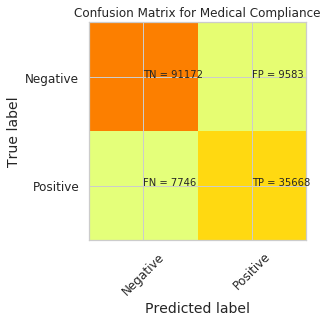

Plots for Precision Recall & ROC can be visualised below


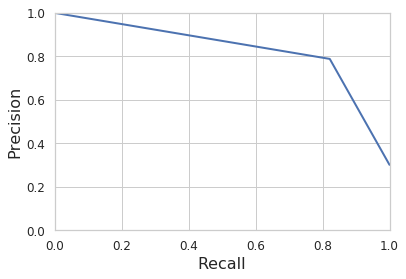

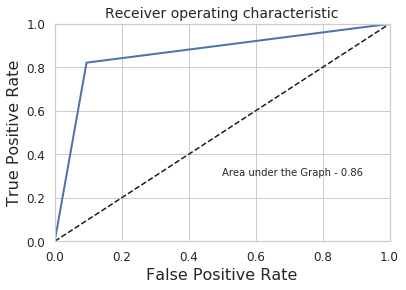

In [24]:
# Initialize our algorithm
log_reg = LogisticRegression(solver = 'lbfgs',random_state=42, n_jobs = -1)
predicted_label = cross_val_predict(log_reg, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)

In [25]:
print("-------------------------------------")
print("Running  Grid Search to tune Hyperparameters ...")

param_grid = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
               'max_iter': [100, 150, 200, 250, 300, 350]}]

get_best_params(log_reg, param_grid, processed_training_data, processed_training_label)

-------------------------------------
Running  Grid Search to tune Hyperparameters ...


/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best parameters : {'solver': 'liblinear', 'max_iter': 100}
Best Score : 0.858861079535763


### Algo 2 : Decision Tree 
F1 Score :  90

Classsification Report - 
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92    100755
         1.0       0.78      0.90      0.84     43414

   micro avg       0.89      0.89      0.89    144169
   macro avg       0.87      0.90      0.88    144169
weighted avg       0.90      0.89      0.90    144169



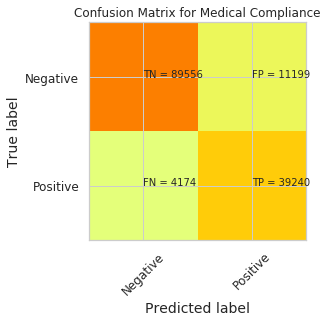

Plots for Precision Recall & ROC can be visualised below


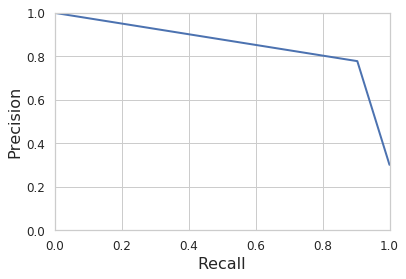

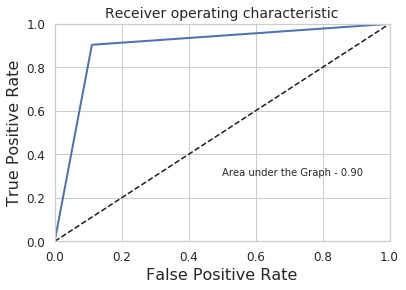

In [26]:
# Initialize our algorithm

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42 )
predicted_label = cross_val_predict(tree_clf, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)

In [27]:
print("-------------------------------------")
print("Running  Grid Search to tune Hyperparameters ...")

param_grid = [{'criterion': ["gini", "entropy"], 
               'max_depth': [2, 3, 4, 5, 7, 9, 12, 15],
               'max_features': [None,'sqrt','log2']}]

get_best_params(tree_clf, param_grid, processed_training_data, processed_training_label)

-------------------------------------
Running  Grid Search to tune Hyperparameters ...
Best parameters : {'max_depth': 4, 'max_features': None, 'criterion': 'gini'}
Best Score : 0.8787342181949195


### Algo 3 : Random Forest Tree 
F1 Score :  88

Classsification Report - 
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92    100755
         1.0       0.78      0.90      0.84     43414

   micro avg       0.89      0.89      0.89    144169
   macro avg       0.87      0.90      0.88    144169
weighted avg       0.90      0.89      0.90    144169



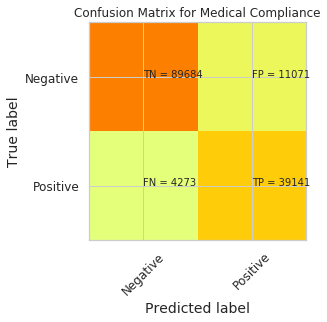

Plots for Precision Recall & ROC can be visualised below


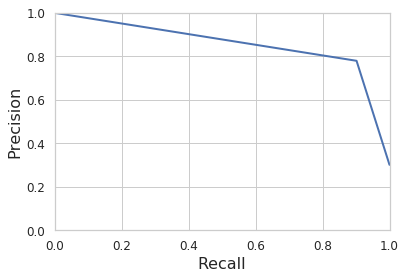

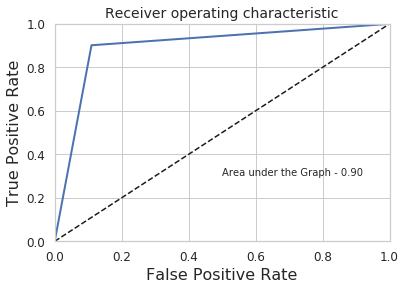

In [28]:
# Initialize our algorithm
forest_clf  = RandomForestClassifier(n_estimators=100, random_state=42 , n_jobs = -1,
                                      max_depth=3)  

predicted_label = cross_val_predict(forest_clf, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)

In [29]:
print("-------------------------------------")
print("Running  Grid Search to tune Hyperparameters ...")

param_grid = [{'n_estimators':[100,200,300,400,500],
               'criterion': ["gini", "entropy"], 
               'max_depth': [2, 3, 4, 5, 7, 9, 12, 15],
               'max_features': [None,'sqrt','log2'],
               'bootstrap': [True,False]
               #,'oob_score': [True,False]
              }]

get_best_params(forest_clf, param_grid, processed_training_data, processed_training_label)

-------------------------------------
Running  Grid Search to tune Hyperparameters ...
Best parameters : {'max_features': 'sqrt', 'bootstrap': True, 'max_depth': 4, 'criterion': 'gini', 'n_estimators': 400}
Best Score : 0.8789763036877619


In [31]:
print("-------------------------------------")
print("Running  Grid Search to tune Hyperparameters ...")

param_grid = [{'n_estimators':[100,200,300,400,500],
               'criterion': ["gini", "entropy"], 
               'max_depth': [2, 3, 4, 5, 7, 9, 12, 15],
               'max_features': [None,'sqrt','log2'],
               'bootstrap': [True],
               'oob_score': [True,False]
              }]

get_best_params(forest_clf, param_grid, processed_training_data, processed_training_label)

-------------------------------------
Running  Grid Search to tune Hyperparameters ...
Best parameters : {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 400, 'max_depth': 4, 'oob_score': True, 'criterion': 'gini'}
Best Score : 0.8789763036877619


In [ ]:
### Algo 4 : Multi-Layer Perceptron

Classsification Report - 
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92    100755
         1.0       0.79      0.88      0.83     43414

   micro avg       0.89      0.89      0.89    144169
   macro avg       0.87      0.89      0.88    144169
weighted avg       0.90      0.89      0.89    144169



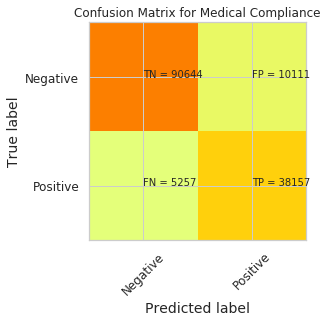

Plots for Precision Recall & ROC can be visualised below


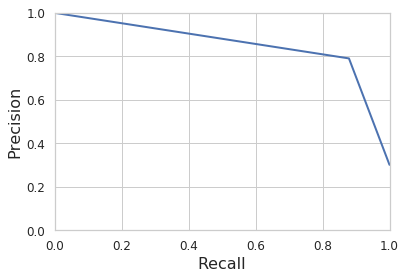

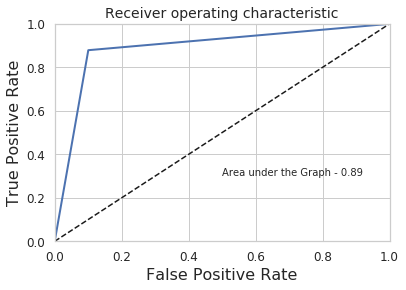

In [32]:
# Initialize our algorithm

mlp_clf  = MLPClassifier(hidden_layer_sizes=(50,) ,random_state=42 ,learning_rate ='adaptive',max_iter=100)

predicted_label = cross_val_predict(mlp_clf, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)

In [35]:
print("-------------------------------------")
print("Running  Grid Search to tune Hyperparameters ...")
param_grid = [{'hidden_layer_sizes':[(50,),(50,100)],
               'learning_rate': ['constant', 'invscaling', 'adaptive'], 
               #'activation ': ['relu'],
               'activation': [ 'relu','logistic', 'tanh'],
               'solver': ['lbfgs', 'sgd', 'adam']}]

get_best_params(mlp_clf, param_grid, processed_training_data, processed_training_label)

-------------------------------------
Running  Grid Search to tune Hyperparameters ...
Best parameters : {'solver': 'lbfgs', 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'activation': 'relu'}
Best Score : 0.8784736381735768


### Algo 3 : Extra Tree Classifiers

Classsification Report - 
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90    100755
         1.0       0.77      0.76      0.76     43414

   micro avg       0.86      0.86      0.86    144169
   macro avg       0.83      0.83      0.83    144169
weighted avg       0.86      0.86      0.86    144169



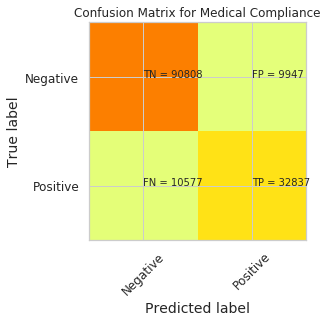

Plots for Precision Recall & ROC can be visualised below


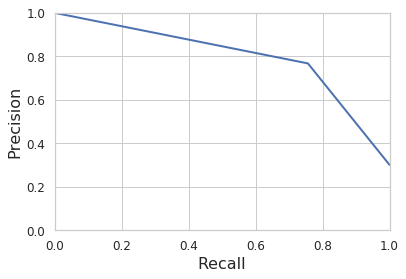

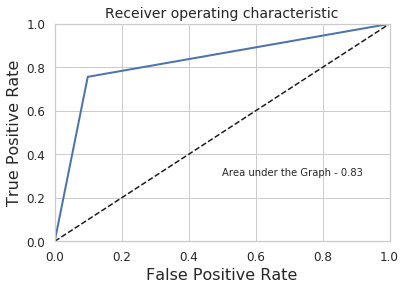

In [36]:
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
predicted_label = cross_val_predict(extra_trees_clf, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)

In [38]:
print("-------------------------------------")
print("Running  Grid Search to tune Hyperparameters ...")
param_grid = [{'n_estimators':[200, 300, 400, 500],
               'criterion': ["gini", "entropy"], 
               'max_depth': [2, 4, 6, 8, 10],
               'max_features': [None,'sqrt','log2'],
               'bootstrap': [True],
               'oob_score': [True,False]}]

get_best_params(extra_trees_clf, param_grid, processed_training_data, processed_training_label)

-------------------------------------
Running  Grid Search to tune Hyperparameters ...
Best parameters : {'bootstrap': True, 'max_features': None, 'n_estimators': 400, 'max_depth': 10, 'oob_score': True, 'criterion': 'gini'}
Best Score : 0.8788474686519158


In [ ]:
### Algo 3 : Support Vector Machine

Classsification Report - 
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92    100755
         1.0       0.79      0.85      0.82     43414

   micro avg       0.89      0.89      0.89    144169
   macro avg       0.86      0.87      0.87    144169
weighted avg       0.89      0.89      0.89    144169



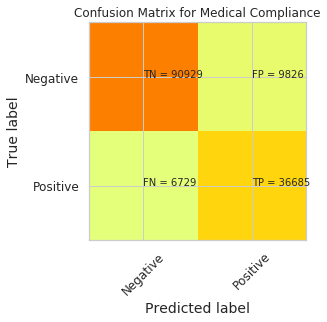

Plots for Precision Recall & ROC can be visualised below


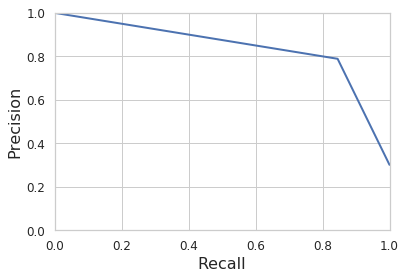

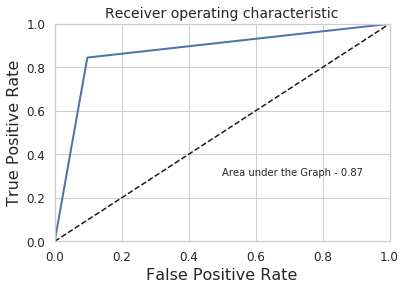

In [39]:
svm_clf = SVC(probability = True ,gamma="auto", random_state=42)
predicted_label = cross_val_predict(svm_clf, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)


In [40]:
print("-------------------------------------")
print("Running  Grid Search to tune Hyperparameters ...")
param_grid = [{'C':[1,10,100], 
               'gamma':['auto','scale'],
               'kernel':['linear','rbf'],
              }]

get_best_params(svm_clf, param_grid, processed_training_data, processed_training_label)

-------------------------------------
Running  Grid Search to tune Hyperparameters ...
Best parameters : {'kernel': 'rbf', 'C': 100, 'gamma': 'auto'}
Best Score : 0.8709424028606629


### Voting Classifier [Ensemble]

In [51]:
log_clf = LogisticRegression(solver="liblinear", max_iter =100 ,random_state=42, n_jobs = -1)
tree_clf = DecisionTreeClassifier(max_depth= 4, max_features = None, criterion= 'gini', random_state=42 )
rnd_clf = RandomForestClassifier(max_features= 'sqrt', bootstrap= True, max_depth= 4, n_jobs = -1,
                                 criterion= 'gini', n_estimators= 400, random_state=42)

extra_trees_clf = ExtraTreesClassifier(n_estimators=400, bootstrap= True, max_features= None, max_depth=10, 
                                       oob_score= True, criterion= 'gini',random_state=42,n_jobs = -1)

                                      
mlp_clf  = MLPClassifier(hidden_layer_sizes=(50,100) ,solver ='lbfgs',random_state=42 ,
                         learning_rate = 'constant',activation= 'relu')

svm_clf = SVC(gamma="auto",kernel ='rbf',C=100, random_state=42,probability = True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard', n_jobs = -1)

Classsification Report - 
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92    100755
         1.0       0.79      0.86      0.82     43414

   micro avg       0.89      0.89      0.89    144169
   macro avg       0.86      0.88      0.87    144169
weighted avg       0.89      0.89      0.89    144169



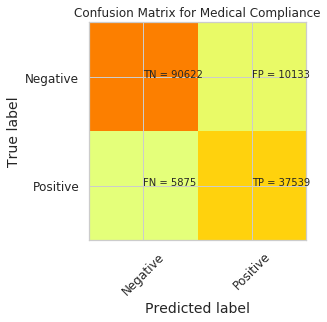

Plots for Precision Recall & ROC can be visualised below


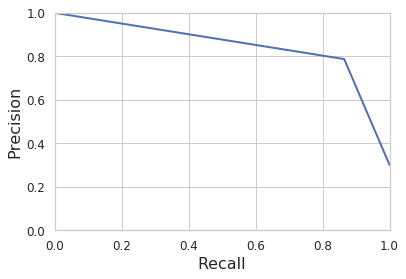

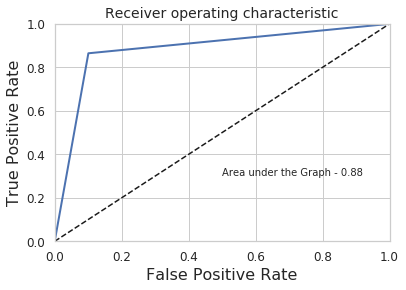

In [43]:
predicted_label = cross_val_predict(voting_clf, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)

Classsification Report - 
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92    100755
         1.0       0.79      0.86      0.82     43414

   micro avg       0.89      0.89      0.89    144169
   macro avg       0.86      0.88      0.87    144169
weighted avg       0.89      0.89      0.89    144169



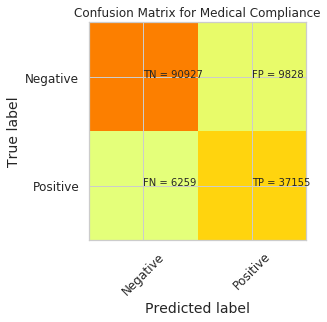

Plots for Precision Recall & ROC can be visualised below


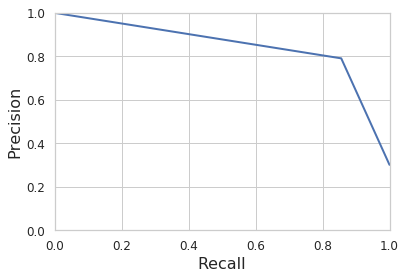

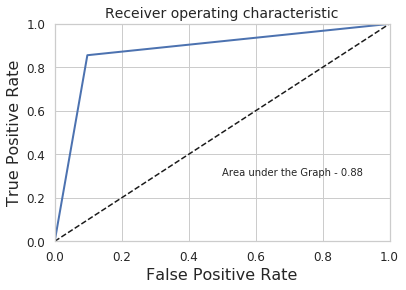

In [44]:
voting_clf.voting = "soft"
predicted_label = cross_val_predict(voting_clf, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)

In [ ]:
# svm_clf = SVC(gamma="auto", random_state=42,probability = True)
# voting_clf = VotingClassifier(
#     estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
#     voting='soft')

predicted_label = cross_val_predict(voting_clf, processed_training_data, processed_training_label, cv=3, n_jobs = -1)
compute_scores(processed_training_label, predicted_label)

### Step 6 : Prediction

From the above experiments we find the the best performing model on the dataset is ______

Hence we use it for prediction

In [ ]:

# Model Definition

classifier = voting_clf.voting = "soft"





In [ ]:
# Prediction
predicted_label = cross_val_predict(classifier, processed_training_data, processed_training_label, cv=3, n_jobs = -1)

# Evaluation

compute_scores(processed_training_label, predicted_label)

In [53]:
classifier = tree_clf

# Fitting the Model over the entire training data provided in the Problem Statement.
# Separating Features & Target for training

training_data = dataset.drop(['Adherence','patient_id'],axis=1)
training_label = dataset[['Adherence']].copy()

# Pre-processing the entire dataset
processed_training_data = full_pipeline.fit_transform(training_data)
processed_training_label = ordinal_encoder.fit_transform(training_label).reshape(-1,)

print("Training the Model ---- ")
# Fitting the model
classifier.fit(processed_training_data, processed_training_label)

print("Test Data ---- ")
# Preparing the test data
test_data = test_set.drop(['patient_id'],axis=1)
print(test_data.info())

processed_test_data = full_pipeline.fit_transform(test_data)

# Running on the given test_data for prediction
prediction = classifier.predict(processed_test_data)
prediction_proba = classifier.predict_proba(processed_test_data)

/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Training the Model ---- 
Test Data ---- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119788 entries, 0 to 119787
Data columns (total 9 columns):
Age                    119788 non-null int64
Gender                 119788 non-null object
Prescription_period    119788 non-null int64
Diabetes               119788 non-null int64
Alcoholism             119788 non-null int64
HyperTension           119788 non-null int64
Smokes                 119788 non-null int64
Tuberculosis           119788 non-null int64
Sms_Reminder           119788 non-null int64
dtypes: int64(8), object(1)
memory usage: 8.2+ MB
None


/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [75]:
result = pd.DataFrame()
result['patient_id'] =  test_set['patient_id']
result['prediction'] =  prediction

# Selecting the Maximum Probality score
result['probability'] =  np.maximum(prediction_proba[:,0],prediction_proba[:,1])

result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119788 entries, 0 to 119787
Data columns (total 3 columns):
patient_id     119788 non-null int64
prediction     119788 non-null float64
probability    119788 non-null float64
dtypes: float64(2), int64(1)
memory usage: 2.7 MB


In [76]:
result.head()

,patient_id,prediction,probability
0,1,1.0,0.826833
1,2,1.0,0.713926
2,3,0.0,0.943232
3,4,0.0,0.950998
4,5,1.0,0.792202


In [80]:
result.prediction.replace((1,0), ('yes', 'no'), inplace=True)
result.head()

,patient_id,prediction,probability
0,1,yes,0.826833
1,2,yes,0.713926
2,3,no,0.943232
3,4,no,0.950998
4,5,yes,0.792202


In [83]:
result.to_csv(os.path.join(PROJECT_OUTPUT_PATH,'prediction.csv'))